In [1]:
# import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

# import fancyimpute as fi
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import variation
from math import isnan

from scipy.cluster.hierarchy import dendrogram,linkage

import sys
sys.path.append("./src/")
import lumberjack
import tree_reader as tr
import tree_braider2 as trbr

In [2]:
counts = np.loadtxt('/Users/boris/taylor/johnston_retina/single_cell/dmel-retina-scRNA/exploration/2018.07.19_Scanpy/log_counts.txt')
header = np.loadtxt("/Users/boris/taylor/johnston_retina/single_cell/dmel-retina-scRNA/exploration/2018.07.19_Scanpy/header.txt",dtype=str)

# counts = np.loadtxt('/Users/boris/taylor/aging_sc/var_filtered_counts.txt')
# header = np.loadtxt("/Users/boris/taylor/aging_sc/var_filtered_header.txt",dtype=str)

# counts = np.loadtxt('/Users/boris/taylor/fan_tendon/log_counts.txt')
# header = np.loadtxt("/Users/boris/taylor/fan_tendon/header.txt",dtype=str)

# counts = np.loadtxt('/Users/boris/taylor/vision/rust_prototype/raw_data/vision_sc/nesterowa_counts.txt')
# header = np.loadtxt('/Users/boris/taylor/vision/rust_prototype/raw_data/vision_sc/nesterowa_gene_header.txt',dtype=str)

# feature_sort = dendrogram(linkage(counts.T,metric='correlation',method='average'),no_plot=True)['leaves']

# counts = counts[cell_sort].T[feature_sort].T
# counts = counts.T[feature_sort].T
# header = header[feature_sort]

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression Unsorted",fontsize=20)
# plt.imshow(counts,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()

# cell_sort = dendrogram(linkage(counts,metric='cos',method='average'),no_plot=True)['leaves']

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Agglomerative",fontsize=20)
# plt.imshow(counts[cell_sort],aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()


print(counts.shape)
print(header.shape)

(2585, 1000)
(1000,)


In [3]:
output_directory = "./prediction/"
raw_text_out = open(output_directory + str("evaluation.txt"),mode='w')



In [4]:

# training_mask = np.random.random(counts.shape[0]) > .1
# testing_mask = np.logical_not(training_mask)

# training_counts = counts[training_mask]
# testing_counts = counts[testing_mask]

training_counts = counts
testing_counts = counts

# forest = tr.Forest.reconstitute('./forest_vision')

forest = lumberjack.fit(training_counts,trees=200,dispersion_mode="ssme",norm="l2",drop='none',sfr=1,in_feature_subsample=200,out_feature_subsample=200,sample_subsample=1000,depth=10,leaves=50,header=header)

# forest.weigh_leaves()

# predicted = forest.predict_matrix(testing_counts)

true_counts = testing_counts

subsampling = 1

# mask = np.loadtxt('./testing/holdout_mask_counts.txt')

# held_out_counts = np.loadtxt('./testing/held_out_counts.txt')

Setting context
Input:(2585, 1000)
Output:(2585, 1000)
CHECK TRUTH
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20
['input.counts', 'tmp.ifh', 'output.counts', 'tmp.ofh']
Generating trees
Running /Users/boris/taylor/vision/rust_prototype/rusty_lumberjack/target/release/lumberjack_1
Command: /Users/boris/taylor/vision/rust_prototype/rusty_lumberjack/target/release/lumberjack_1 generate -ic /var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/input.counts -oc /var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/output.counts -o /var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp -auto -ifh /var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.ifh -ofh /var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.ofh -trees 200 -dispersion_mode ssme -norm l2 -drop none -sfr 1 -in_feature_subsample 200 -out_feature_subsample 200 -sample_subsample 1000 -depth 10 -leaves 50
Trying to readline

0 0 0 0 2.5494191646575928 0
100

0 0 0 0 3

Made rank table with 1000 features, 2585 samples:
Initializing: 0
Initializing: 200
Initializing: 400
Initializing: 600
Initializing: 800
Made rank table with 1000 features, 2585 samples:
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.0.compact
Prototype tree: 1000,1000,2585
Parameters:200,200,1000
Unwrapping tree
Tree Pool: Request for tree: 1
Tree Pool: Deriving 1
Deriving from prototype: 1000,200,200
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 1
SSME
Tree Pool: Sending 1
Tree Pool: Request for tree: 2
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.1.compact
Tree Pool: Deriving 2
Deriving from prototype: 1000,200,200
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 2
SSME
Tree Pool: Sending 2
Tree Pool: Request for tree: 3
Tree Pool: Deriving 3
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz

Tree Pool: Sending 27
Tree Pool: Request for tree: 28
Tree Pool: Deriving 28
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.27.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 28
SSME
Tree Pool: Sending 28
Tree Pool: Request for tree: 29
Tree Pool: Deriving 29
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.28.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 29
SSME
Tree Pool: Sending 29
Tree Pool: Request for tree: 30
Tree Pool: Deriving 30
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.29.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 30
SSME
Tree Pool: Sending 30
Tree Pool: Request for tree: 31
Tree Pool: Deriving 31
Deriving from 

Tree Pool: Sending 55
Tree Pool: Request for tree: 56
Tree Pool: Deriving 56
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.55.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 56
SSME
Tree Pool: Sending 56
Tree Pool: Request for tree: 57
Tree Pool: Deriving 57
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.56.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 57
SSME
Tree Pool: Sending 57
Tree Pool: Request for tree: 58
Tree Pool: Deriving 58
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.57.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 58
SSME
Tree Pool: Sending 58
Tree Pool: Request for tree: 59
Tree Pool: Deriving 59
Deriving from 

Tree Pool: Sending 83
Tree Pool: Request for tree: 84
Tree Pool: Deriving 84
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.83.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 84
SSME
Tree Pool: Sending 84
Tree Pool: Request for tree: 85
Tree Pool: Deriving 85
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.84.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 85
SSME
Tree Pool: Sending 85
Tree Pool: Request for tree: 86
Tree Pool: Deriving 86
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.85.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 86
SSME
Tree Pool: Sending 86
Tree Pool: Request for tree: 87
Tree Pool: Deriving 87
Deriving from 

Tree Pool: Sending 110
Tree Pool: Request for tree: 111
Tree Pool: Deriving 111
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.110.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 111
SSME
Tree Pool: Sending 111
Tree Pool: Request for tree: 112
Tree Pool: Deriving 112
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.111.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 112
SSME
Tree Pool: Sending 112
Tree Pool: Request for tree: 113
Tree Pool: Deriving 113
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.112.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 113
SSME
Tree Pool: Sending 113
Tree Pool: Request for tree: 114
Tree Pool: Deriving 

Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 137
SSME
Tree Pool: Sending 137
Tree Pool: Request for tree: 138
Tree Pool: Deriving 138
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.137.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 138
SSME
Tree Pool: Sending 138
Tree Pool: Request for tree: 139
Tree Pool: Deriving 139
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.138.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 139
SSME
Tree Pool: Sending 139
Tree Pool: Request for tree: 140
Tree Pool: Deriving 140
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.139.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 140


Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 164
SSME
Tree Pool: Sending 164
Tree Pool: Request for tree: 165
Tree Pool: Deriving 165
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.164.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 165
SSME
Tree Pool: Sending 165
Tree Pool: Request for tree: 166
Tree Pool: Deriving 166
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.165.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 166
SSME
Tree Pool: Sending 166
Tree Pool: Request for tree: 167
Tree Pool: Deriving 167
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.166.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 167


Tree Pool: Sending 191
Tree Pool: Request for tree: 192
Tree Pool: Deriving 192
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.191.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 192
SSME
Tree Pool: Sending 192
Tree Pool: Request for tree: 193
Tree Pool: Deriving 193
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.192.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 193
SSME
Tree Pool: Sending 193
Tree Pool: Request for tree: 194
Tree Pool: Deriving 194
Deriving from prototype: 1000,200,200
Serializing to:
/var/folders/b2/7244d5s15ys_gl3k8w1hzt0h0000gn/T/tmpdz4gna20/tmp.193.compact
Unwrapping tree
Derived from prototype, rank table size: (200, 1000)
Tree Pool: Growing 194
SSME
Tree Pool: Sending 194
Tree Pool: Request for tree: 195
Tree Pool: Deriving 

In [5]:
forest.backup('./forest_johnston_ihmm')
# forest.backup('./forest_johnston_ssme')
# forest.backup('./forest_johnston_flat_sme')
# forest.backup('./forest_johnston_var')
# forest.backup('./forest_fan_ssme')
# forest.backup('./forest_vision')

In [6]:
# Optional adjustment to truncate lower-expressing genes.
# expression_level_mask = np.mean(true_counts,axis=0) > 1
# true_counts = true_counts.T[expression_level_mask].T
# predicted = predicted.T[expression_level_mask].T

In [7]:


# raw_text_out.write("=================================================\n")
# raw_text_out.write("Basic evaluation: \n")

# raw_text_out.write("Pearson R\n")
# raw_text_out.write(str(pearsonr(predicted.flatten(),true_counts.flatten())) + "\n")

# raw_text_out.write("MSE\n")
# raw_text_out.write(str(np.mean((predicted.flatten() - true_counts.flatten()) ** 2)) + "\n")

# raw_text_out.write("MAE\n")
# raw_text_out.write(str(np.mean(np.abs(predicted.flatten() - true_counts.flatten()))) + "\n")


# raw_text_out.close()

In [8]:
# sys.path.append("/Users/boris/haxx/python/smooth_density_graph/")
# import smooth_density_graph as sdg

# # forest.reset_clusters()
# from scipy.cluster.hierarchy import linkage,dendrogram

# encoding = forest.node_sample_encoding(forest.leaves())

# print(np.sum(np.sum(encoding,axis=1) == 0))
# cell_sort = dendrogram(linkage(encoding,metric='cos',method='average'),no_plot=True)['leaves']
# leaf_sort = dendrogram(linkage(encoding.T,metric='cos',method='average'),no_plot=True)['leaves']
# feature_sort = dendrogram(linkage(forest.input.T,metric='correlation',method='average'),no_plot=True)['leaves']


# plt.figure(figsize=(10,10))
# # plt.imshow(encoding,aspect='auto',cmap='binary')
# plt.imshow(encoding[cell_sort].T[leaf_sort].T,aspect='auto',cmap='binary')
# plt.show()


# print(np.sum(np.isnan(encoding).flatten()))

# cell_clusterings = forest.cluster_samples_encoding(subsample=1200,distance='cos',k=10,steps=10,override=False,verbose=True)
# leaf_clusterings = forest.cluster_leaf_samples(subsample=4000,distance='cos',k=10,steps=10,override=False,verbose=True)

# cell_order = np.argsort(cell_clusterings)
# leaf_order = np.argsort(leaf_clusterings)

# clustered_counts = forest.input[cell_order].T[feature_sort].T
# # clustered_counts = encoding[cell_order].T[feature_sort].T

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Forest Clustering",fontsize=20)
# plt.imshow(clustered_counts,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()


# print("===================")

# for cluster in forest.sample_clusters:
#     print(len(cluster.samples))

# print("===================")

# for cluster in forest.leaf_clusters:
#     print(len(cluster.nodes))

# print("===================")
# print("===================")
# print("===================")
# print(len(forest.sample_clusters))
# print(len(forest.leaf_clusters))

In [9]:
# forest.cluster_samples_encoding(subsample=1000,distance='cos',override=True,k=10,steps=10,verbose=True)
# forest.sample_clusters

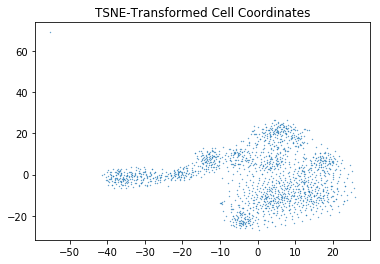

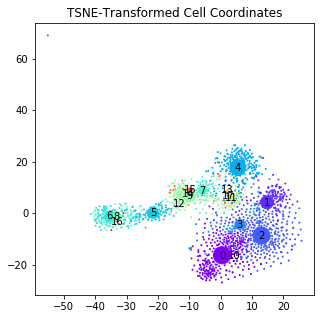

In [10]:
# forest.leaf_clusters[0].ranked_mean_gains()
# forest.leaf_clusters[0].prerequisite_frequency()
# forest.leaf_clusters[3].biological_cluster_summary()
# print(forest.weighted_node_vector_prediction(forest.leaf_clusters[0].nodes))
# print(forest.weighted_node_vector_prediction([forest.prototype.root]))
forest.tsne_encoding(override=True)
forest.plot_cell_clusters()
# forest.plot_cell_clusters(colorize=False)

In [11]:
# from sklearn.manifold import TSNE
# forest.trees[0].root.child_clusters
# nodes,labels,encoding = forest.cluster_divergence(subsample=2300,k=10,distance='manhattan',verbose=True,steps=10,auto=True)
# print(len(forest.divergence_clusters[4].nodes[2].samples))

# encoding_ordering = np.argsort(labels)

# plt.figure(figsize=(10,10))
# plt.imshow(encoding,aspect='auto')
# plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(encoding[encoding_ordering],aspect='auto')
# plt.show()

# tc = TSNE().fit_transform(forest.counts)
# tc = forest.tsne(no_plot=True)

# forest.leaf_clusters[3].plot_cell_counts(cmap='magma')


# for leaf_cluster in forest.leaf_clusters:
#     print(leaf_cluster.id)
#     leaf_cluster.plot_cell_counts()
    
# forest.divergence_clusters[x].plot_cell_counts()
# print([len(dc.nodes) for dc in forest.divergence_clusters])
# print([n.level for n in forest.divergence_clusters[x].nodes])
# print([n.feature for n in forest.divergence_clusters[x].nodes])
# plt.figure(figsize=(10,10))
# plt.hist([n.feature for n in forest.divergence_clusters[x].nodes])
# plt.xticks(rotation='vertical')
# plt.show()

In [12]:
# ss_i = forest.truth_dictionary.feature_dictionary['ss']
# o_i = forest.truth_dictionary.feature_dictionary['Optix']
# oc_i = forest.truth_dictionary.feature_dictionary['oc']
# scrt_i = forest.truth_dictionary.feature_dictionary['scrt']
# skip_i = forest.truth_dictionary.feature_dictionary['SKIP']
# gasp_i = forest.truth_dictionary.feature_dictionary['Gasp']
# rox1l_i = forest.truth_dictionary.feature_dictionary['lncRNA:roX1']
# rox2l_i = forest.truth_dictionary.feature_dictionary['lncRNA:roX2']
# # sxl_i = forest.truth_dictionary.feature_dictionary['Sxl']
# serp_i = forest.truth_dictionary.feature_dictionary['Spn43Aa']
# appl_i = forest.truth_dictionary.feature_dictionary['Appl']
# nrm_i = forest.truth_dictionary.feature_dictionary['nrm']
# gl_i = forest.truth_dictionary.feature_dictionary['gl']
# tyn_i = forest.truth_dictionary.feature_dictionary['tyn']
# aop_i = forest.truth_dictionary.feature_dictionary['aop']
# hth_i = forest.truth_dictionary.feature_dictionary['hth']
# nw_i = forest.truth_dictionary.feature_dictionary['nw']
# espl_i = forest.truth_dictionary.feature_dictionary['E(spl)m8-HLH']
# ance_i = forest.truth_dictionary.feature_dictionary['Ance']
# mmp2_i = forest.truth_dictionary.feature_dictionary['Mmp2']
# rbp6_i = forest.truth_dictionary.feature_dictionary['Rbp6']
# nrv3_i = forest.truth_dictionary.feature_dictionary['nrv3']

# cell_labels = forest.sample_labels

# plt.figure(figsize=(12,10))
# plt.title("Simple Cell Clusters")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=cell_labels,cmap='rainbow')
# plt.show()

# plt.figure(figsize=(10,10))
# plt.title("oc",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,oc_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Optix",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,o_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Spineless",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,ss_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("scrt",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,scrt_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("SKIP",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,skip_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Gasp",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,gasp_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Rox1Lnc",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,rox1l_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Rox2Lnc",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,rox2l_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Spn43Aa",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,serp_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Appl",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,appl_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("nrm",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,nrm_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("gl",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,gl_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("tyn",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,tyn_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("aop",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,aop_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("hth",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,hth_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("nw",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,nw_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("E(spl)m8-HLH",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,espl_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Ance",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,ance_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Mmp2",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,mmp2_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Rbp6",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,rbp6_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Nrv3",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,nrv3_i],cmap='magma')
# plt.colorbar()
# plt.show()

In [13]:
# forest.leaf_clusters[8].biological_cluster_summary()
# forest.leaf_clusters[7].average_prereq_freq_level()
# forest.leaf_clusters[11].average_prereq_freq_level()
# # forest.leaf_clusters[11].biological_cluster_summary()
# # forest.leaf_clusters[18].biological_cluster_summary()
# # print(forest.leaf_clusters[7].ranked_feature_error_gain()[0][-20:])
# # print(forest.leaf_clusters[11].ranked_feature_error_gain()[0][-20:])
# # print(forest.leaf_clusters[18].ranked_feature_error_gain()[0][-20:])

# cl0_cells = forest.sample_clusters[0].samples
# cl5_cells = forest.sample_clusters[5].samples
# cl3_cells = forest.sample_clusters[3].samples
# cl9_cells = forest.sample_clusters[9].samples
# cl7_cells = forest.sample_clusters[7].samples

# plt.figure()
# plt.title("E(spl)m8-HLH across all cells",fontsize=25)
# plt.hist(forest.counts[:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 0",fontsize=25)
# plt.hist(forest.counts[cl0_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 3",fontsize=25)
# plt.hist(forest.counts[cl3_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 5",fontsize=25)
# plt.hist(forest.counts[cl5_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 7",fontsize=25)
# plt.hist(forest.counts[cl7_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 9",fontsize=25)
# plt.hist(forest.counts[cl9_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()


# plt.figure()
# plt.title("Nw across all cells",fontsize=25)
# plt.hist(forest.counts[:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 0",fontsize=25)
# plt.hist(forest.counts[cl0_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 3",fontsize=25)
# plt.hist(forest.counts[cl3_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 5",fontsize=25)
# plt.hist(forest.counts[cl5_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 7",fontsize=25)
# plt.hist(forest.counts[cl7_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 9",fontsize=25)
# plt.hist(forest.counts[cl9_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()


In [14]:
# import random
# print(forest.trees[0].root.child_clusters)
# print([l.cluster for l in forest.trees[0].root.leaves()])
# forest.leaves()[0].cluster
# forest.leaves()[0].find_cluster_divergence(1889).child_clusters


# distance_mtx = np.zeros((len(forest.leaf_clusters),len(forest.leaf_clusters)))

# for i,c1 in enumerate(forest.leaf_clusters):
#     for j,c2 in enumerate(forest.leaf_clusters):
        
#         _nodes,distances = forest.find_leaf_cluster_divergence(c1.id,c2.id)
        
#         md = np.mean(distances)
#         if np.isnan(md):
#             md = 5 + random.random()
#         distance_mtx[i,j] = md

# plt.figure(figsize=(10,10))
# cluster_sort = dendrogram(linkage(distance_mtx,metric='cos',method='average'),no_plot=False)['leaves']
# plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(distance_mtx[cluster_sort].T[cluster_sort].T,aspect='auto')
# plt.colorbar()
# plt.show()



In [15]:
# cluster_matrix = np.zeros((len(forest.sample_clusters),len(forest.leaf_clusters)))
# for i,sample_cluster in enumerate(forest.sample_clusters):
#     leaf_cluster_frequency = sample_cluster.leaf_cluster_frequency(plot=False)[1]
#     for j,lcf in enumerate(leaf_cluster_frequency):
#         cluster_matrix[i,j] = lcf
        
# plt.figure(figsize=(20,10))
# plt.title("Occurrence of Leaf Clusters in Cell Clusters",fontsize=30)
# plt.imshow(np.log(cluster_matrix+1),aspect='auto')
# plt.xlabel("Leaf Clusters",fontsize=24)
# plt.ylabel("Cell Clusters",fontsize=24)
# plt.colorbar()
# plt.show()

# vertical_order = dendrogram(linkage(cluster_matrix,metric='correlation'),no_plot=True)['leaves']
# horizontal_order = dendrogram(linkage(cluster_matrix.T,metric='correlation'),no_plot=True)['leaves']

# rearranged_sample_ticks = np.arange(len(forest.sample_clusters))[vertical_order]
# rearranged_leaf_ticks = np.arange(len(forest.leaf_clusters))[horizontal_order]

# plt.figure(figsize=(20,10))
# plt.title("Occurrence of Leaf Clusters in Cell Clusters",fontsize=30)
# plt.imshow(np.log(cluster_matrix+1)[vertical_order].T[horizontal_order].T,aspect='auto')
# plt.xlabel("Leaf Clusters",fontsize=24)
# plt.ylabel("Cell Clusters",fontsize=24)
# plt.xticks(np.arange(len(rearranged_leaf_ticks)),rearranged_leaf_ticks)
# plt.yticks(np.arange(len(rearranged_sample_ticks)),rearranged_sample_ticks)
# plt.colorbar()
# plt.show()

In [16]:
# forest.prereq_summary()

In [17]:
# plt.figure()
# dendrogram(linkage(forest.sample_cluster_coordinate_matrix()),labels=[cluster.id for cluster in forest.sample_clusters])
# plt.show()

In [18]:
# forest.sample_clusters[4].leaf_cluster_frequency()

In [19]:
# forest.leaf_clusters[3].biological_cluster_summary()

In [20]:
# forest.leaf_clusters[0].average_prereq_freq_level()
# forest.leaf_clusters[1].average_prereq_freq_level()
# forest.leaf_clusters[6].average_prereq_freq_level()


In [21]:
# # from sklearn.cluster import DBSCAN
# from hdbscan import HDBSCAN

# encoding = forest.node_sample_encoding(forest.leaves())

# d_cell_clusters = HDBSCAN(min_samples=5).fit_predict(encoding)
# d_leaf_clusters = HDBSCAN(min_samples=5).fit_predict(encoding.T)

# d_cell_ordering = np.argsort(d_cell_clusters)
# # leaf_ordering = np.argsort(d_leaf_clusters)
# d_leaf_ordering = dendrogram(linkage(encoding.T,metric='cos',method='average'),no_plot=True)['leaves']


# plt.figure(figsize=(20,8))
# plt.imshow(encoding[d_cell_ordering].T[d_leaf_ordering].T,aspect='auto',cmap='binary')
# plt.show()

# plt.figure(figsize=(20,8))
# plt.imshow(training_counts[d_cell_ordering],aspect='auto')
# plt.show()

# print(set(d_cell_clusters))

In [22]:
# d_p_cell_clusters = HDBSCAN(min_samples=5).fit_predict(training_counts)
# d_p_feature_clusters = HDBSCAN(min_samples=5).fit_predict(training_counts.T)

# d_p_cell_ordering = np.argsort(d_p_cell_clusters)
# # d_p_feature_ordering = np.argsort(d_p_feature_clusters)

# plt.figure(figsize=(20,8))
# plt.imshow(training_counts[d_p_cell_ordering],aspect='auto',cmap='binary')
# plt.show()

# print(set(d_p_cell_clusters))

In [23]:
# from sklearn.manifold import TSNE

# # t_coordinates = TSNE().fit_transform(forest.node_sample_encoding(forest.leaves()))
# t_coordinates = TSNE().fit_transform(forest.counts)

# plt.figure(figsize=(15,10))
# plt.title("Cells Transformed by TSNE (Arbitrary Units)",fontsize=20)
# plt.scatter(t_coordinates[:,0],t_coordinates[:,1],s=.1)
# plt.show()

# # for cluster in set(cell_clusters):
# #     print(np.sum(np.array(cell_clusters) == cluster))

In [24]:
# sys.path.append("/Users/boris/haxx/python/smooth_density_graph/")
# import smooth_density_graph as sdg

# # encoding = forest.node_sample_encoding(forest.leaves())

# sdg_encoding_cell_clusters = sdg.fit_predict(encoding,"fitpredict",subsample=1800,k=5,steps=10,verbose=True)

# sdg_encoding_cell_ordering = np.argsort(sdg_cell_clusters)

# # sdg_leaf_clusters = sdg.fit_predict(encoding.T,"fitpredict",subsample=2300,k=5,steps=10,verbose=True)

# # sdg_leaf_ordering = np.argsort(sdg_leaf_clusters)

# sdg_count_cell_clusters = sdg.fit_predict(forest.counts,"fitpredict",subsample=1800,k=5,steps=10,verbose=True)

# sdg_count_cell_ordering = np.argsort(sdg_count_cell_clusters)

# sdg_feature_clusters = sdg.fit_predict(forest.counts.T,"fitpredict",subsample=750,k=5,steps=10,verbose=True)

# sdg_feature_ordering = np.argsort(sdg_feature_clusters)

# tc = forest.tsne(no_plot=True)
# density = sdg.fit_predict(forest.node_sample_encoding(forest.leaves()),command="density",subsample=2000,k=5,steps=5,verbose=True)

# plt.figure(figsize=(15,10))
# plt.scatter(tc[:,0],tc[:,1],c=np.log(density),s=20,alpha=.7,cmap='viridis')
# plt.scatter(tc[:,0],tc[:,1],c=density,s=30,alpha=.7,cmap='magma')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Smooth Gradient Graph",fontsize=20)
# plt.imshow(forest.counts[sdg_encoding_cell_ordering].T[sdg_feature_ordering].T,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# # plt.colorbar()
# plt.show()

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Smooth Gradient Graph",fontsize=20)
# plt.imshow(forest.counts[sdg_count_cell_ordering].T[sdg_feature_ordering].T,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# # plt.colorbar()
# plt.show()




In [25]:
# from sklearn.cluster import KMeans

# k_cell_clusters = KMeans(n_clusters=10).fit_predict(counts)

# k_cell_ordering = np.argsort(k_cell_clusters)

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, K-Means",fontsize=20)
# plt.imshow(counts[k_cell_ordering],aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()

In [26]:
# import gravity_clustering as grc

# encoding = forest.node_sample_encoding(forest.leaves())

# g_cell_clusters = grc.fit_predict(encoding,'mobile',sample_sub=500,smoothing=3,step_fraction=.5,steps=1000,borrow=1,verbose=True)
# g_leaf_clusters = grc.fit_predict(encoding.T,'mobile',sample_sub=500,smoothing=3,step_fraction=.5,steps=1000,borrow=1,verbose=True)

# g_cell_ordering = np.argsort(g_cell_clusters)
# g_leaf_ordering = np.argsort(g_leaf_clusters)

# plt.figure()
# plt.imshow(encoding[g_cell_ordering].T[g_leaf_ordering].T,aspect='auto',cmap='binary')
# plt.show()

In [27]:
# forest.node_sample_encoding(forest.leaves())
# forest.leaves()[3].samples
# forest.trees[3].plot()
# forest.trees[3].tree_movie('./tree_movies/m1/pr1')
# forest.trees[4].tree_movie('./tree_movies/m2/pr1')

In [28]:
# zero_mask = counts == 0
# zero_sum = np.sum(zero_mask,axis=0)
# zero_percentrage = zero_sum / counts.shape[0]

# plt.figure("sparsity_graph",figsize=(15,10))
# plt.title("Sparsity of Features in Fly Retina Dataset",fontsize=20)
# plt.hist(zero_percentrage,bins=np.arange(0,1.05,0.05))
# plt.xlabel("Sparsity (Fraction of values = 0)",fontsize=15)
# plt.ylabel("Frequency",fontsize=15)
# plt.show()

In [29]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < (subsampling/10)

# plt.figure("general_scatter")
# plt.title("True Expression vs Predicted Expression")
# plt.scatter(true_counts.flatten()[random_mask],predicted.flatten()[random_mask],s=.1,alpha=.3)
# plt.xlabel("True Expression")
# plt.ylabel("Predicted Expression")
# plt.savefig(output_directory+"general_scatter.png")

In [30]:

# plt.figure("mae_vs_mean",figsize=(20,4))
# plt.title("Mean Absolute Error of Feature Predictions vs Mean Feature Value")
# plt.scatter(np.mean(true_counts,axis=0),np.mean(np.abs(true_counts - predicted), axis=0),s=.1)
# plt.plot([0,4],[0,4],c='r')
# plt.xlabel("Mean Gene Expression")
# plt.ylabel("Mean Absolute Error")
# plt.ylim((0,4))
# plt.savefig(output_directory+"mae_vs_mean.png")

# # Calculate MAE
# mae = np.mean(np.abs(true_counts - np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1))), axis=0)

# plt.figure("mean_abs_dev_vs_mean",figsize=(20,4))
# plt.title("Mean Absolute Deviation of Features vs Expression Level")
# plt.scatter(np.mean(true_counts,axis=0),mae,s=.1)
# plt.plot([0,4],[0,4],c='r')
# plt.xlabel("Mean Gene Expression")
# plt.ylabel("Mean Absolute Deviation")
# plt.ylim((0,4))
# plt.savefig(output_directory+"mean_abs_dev_vs_mean.png")

In [31]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

# plt.figure("bimodal_scatter_by_mean",figsize=(6,4))
# plt.title("Observed Expressions Vs Mean Expression of Feature")
# plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],true_counts.flatten()[random_mask],s=.1,alpha=.1, label="Observed Expression")
# # plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
# plt.xlabel("Mean Expression")
# plt.ylabel("Observed Expression")
# plt.xlim(0,4)
# plt.legend()
# plt.savefig(output_directory+"bimodal_scatter_by_mean.png")

# for cluster in forest.sample_clusters:
#     cluster_samples = cluster.samples
#     cluster_counts = forest.counts[cluster_samples]
#     mean_expression = np.mean(cluster_counts,axis=0)
#     print(cluster_counts.shape)
#     plt.figure()
#     plt.scatter(np.tile(mean_expression,(cluster_counts.shape[0],1)).flatten(),cluster_counts.flatten(),s=.1,alpha=.1)
#     plt.xlim(0,4)
#     plt.show()

In [32]:
# # print true_counts[:10,:10]

# random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

# plt.figure("bimodal_scatter_by_mean_predicted",figsize=(20,4))
# plt.title("Predicted Values Vs Observed Means")
# plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],predicted.flatten()[random_mask],s=.1,alpha=.1,label="Expression")
# plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='m',s=.5,label="Medians")
# plt.scatter(np.mean(true_counts,axis=0),np.mean(true_counts,axis=0),c='c',s=.5,label="Means")
# plt.xlim(0,3)
# plt.legend()
# plt.savefig(output_directory+"bimodal_scatter_by_mean_predicted.png")


In [33]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

# plt.figure("error_scatter_by_mean", figsize=(20,4))
# plt.title("Observed Error vs Observed Mean of Feature")
# plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],(true_counts - predicted).flatten()[random_mask],alpha=.1,s=.1)
# plt.xlabel("Mean Expression")
# plt.ylabel("Predicted Expression")
# plt.savefig(output_directory+"error_scatter_by_mean.png")

In [34]:
# plt.figure("mean_error_vs_mean",figsize=(20,4))
# plt.title("Mean Absolute Error Vs Mean Expression of Gene")
# plt.scatter(np.mean(true_counts,axis=0),np.mean(np.abs(true_counts-predicted),axis=0),s=.1,c=np.std(true_counts,axis=0))
# plt.colorbar(label="Standard Deviation of Feature")
# # plt.plot([0,3],[0,3])
# plt.ylim((0,4))
# plt.xlabel("Mean Expression")
# plt.ylabel("Mean Error")
# plt.savefig(output_directory+"mean_error_vs_mean.png")

In [35]:
# plt.figure("mean_error_vs_std",figsize=(4,4))
# plt.title("Mean Absolute Error Vs Standard Deviation of Gene Expression")
# plt.scatter(np.std(true_counts,axis=0),np.mean(np.abs(true_counts-predicted),axis=0),s=.1)
# # plt.colorbar(label="Standard Deviation of Feature")
# plt.plot([0,4],[0,4])
# plt.ylim((0,4))
# plt.xlim((0,4))
# plt.xlabel("Standard Deviation")
# plt.ylabel("Mean Error")
# plt.savefig(output_directory+"mean_error_vs_std.png")

In [36]:
# # true_counts = np.loadtxt('../raw_data/counts.txt')
# # predicted = np.loadtxt('./predictions/combined_mixed')

# correlations = []

# for i in range(true_counts.shape[1]):
    
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
        

# print(len(correlations))

# plt.figure("correlation_vs_mean",figsize=(20,4))
# plt.title("Correlation of Predictions to Features per Feature")
# plt.scatter(np.mean(true_counts,axis=0),correlations,s=.1,c=np.std(true_counts,axis=0))
# plt.colorbar(label="Standard Deviation of Feature")
# plt.xlabel("Mean Expression")
# plt.ylabel("Prediction Correlation")
# plt.savefig(output_directory+"correlation_vs_mean.png")

In [37]:
# from scipy.stats import linregress

# x = np.std(true_counts,axis=0)
# y = np.mean(true_counts-predicted,axis=0)

# slope, intercept, rvalue, pvalue, std_err = linregress(x, y=y)

# plt.figure("mean_error_vs_variance")
# plt.title("Standard Deviation vs Mean Error")
# plt.scatter(x,y,s=.1)
# # plt.plot(x,x*slope + intercept, 'r', label = str(np.around(rvalue,decimals=3)))
# plt.plot([0,3],[0,3])
# plt.plot([0,3],[0,-3])
# plt.ylim((-1,1))
# plt.xlabel("Standard Deviation")
# plt.ylabel("Mean Error")
# plt.legend()
# plt.savefig(output_directory+"mean_error_vs_variance.png")

In [38]:
# # predicted = np.loadtxt('./predictions/combined_prediction')
# correlations = []

# for i in range(true_counts.shape[1]):
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
# print(len(correlations))

    
# plt.figure("correlation_vs_mean",figsize=(20,4))
# plt.title("Correlation of Predictions vs Expression Level")
# plt.scatter(correlations,np.mean(true_counts,axis=0),s=.3,c=variation(true_counts,axis=0))
# plt.ylabel("Mean Expression")
# plt.xlabel("Correlation")
# plt.colorbar(label="Coefficient of Variation")
# plt.clim(0,10)
# plt.savefig(output_directory+"correlation_vs_mean_vs_cov.png",dpi=500)

In [39]:
# correlations = []

# for i in range(true_counts.shape[1]):
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
    
# print(len(correlations))

# plt.figure("correlation_vs_cov")
# plt.title("Correlation of features vs Coefficient of Variance")
# plt.xlabel("Coefficient of Variation")
# plt.ylabel("Correlation")
# plt.scatter(variation(true_counts,axis=0),correlations,s=.1,c=np.std(true_counts,axis=0))
# plt.colorbar(label="Standard Deviation of Feature")
# plt.xlim(0,2)
# plt.show()

In [40]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < (subsampling/10.0)

# errors = true_counts - predicted

# plt.figure("error_vs_true_expression")
# plt.title("Error vs True Expression")
# plt.scatter(true_counts.flatten()[random_mask],errors.flatten()[random_mask],s=.1,alpha=.3,c=np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],cmap='inferno')
# plt.xlabel("True Expression")
# plt.ylabel("Error")
# plt.colorbar(label="Mean expression of gene")
# plt.savefig(output_directory+"error_vs_true_expression.png")

In [41]:
# error = predicted - true_counts 

# mean_cell_error = np.mean(error,axis=1)
# mean_gene_error = np.mean(error,axis=0)

# print(mean_gene_error.shape)
# print(mean_cell_error.shape)

# plt.figure()
# plt.title("Distribution of Mean Feature Errors")
# plt.hist(mean_gene_error,bins=20)
# plt.xlabel("Mean Error")
# plt.ylabel("Frequency")
# plt.show()

# plt.figure()
# plt.title("Distribution of Mean Cell Errors")
# plt.hist(mean_cell_error,bins=20)
# plt.xlabel("Mean Error")
# plt.ylabel("Frequency")
# plt.show()


In [42]:
# expression_sorted_features = true_counts.T[np.argsort(np.mean(true_counts,axis=0))].T
# expression_sorted_prediction = predicted.T[np.argsort(np.mean(true_counts,axis=0))].T


# plt.figure("predictability")
# plt.title("Correlation of Features to Other Features, Sorted By Mean Expression")
# plt.imshow(np.corrcoef(expression_sorted_features.T))
# plt.colorbar(label="Correlation")
# plt.show()


In [43]:
# expression_sorted_features = forest.counts.T[np.argsort(np.mean(forest.counts,axis=0))].T

# random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

# plt.figure("ranked_feature_expression",figsize=(20,4))
# plt.title("Observed Expressions For Each Feature Ranked By Mean Expression")
# plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],expression_sorted_features.flatten()[random_mask],s=.1,alpha=.1, label="Observed Expression")
# # plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
# plt.xlabel("Feature Rank")
# plt.ylabel("Observed Expression")
# plt.ylim((0,10))
# plt.legend()
# plt.savefig(output_directory+"rank_ordered_expresssion.png")

# for cluster in forest.sample_clusters:
#     cluster_samples = cluster.samples
#     cluster_counts = expression_sorted_features[cluster_samples]
#     print(cluster_counts.shape)
#     plt.figure(figsize=(20,4))
#     plt.scatter(np.tile(np.arange(cluster_counts.shape[1]),(cluster_counts.shape[0],1)).flatten(),cluster_counts.flatten(),s=.5,alpha=.5)
#     plt.show()

In [44]:
# def quick_hetorskedasticity(feature):
#     sorted_feature = sorted(feature)
#     first = sorted_feature[:int(len(sorted_feature)/2)]
#     second = sorted_feature[int(len(sorted_feature)/2):]
#     fv = np.var(first)
#     sv = np.var(second)
#     return fv,sv

# expression_sorted_features.shape

# # random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

# heteroskedasticity = [quick_hetorskedasticity(feature)[0]/quick_hetorskedasticity(feature)[1] for feature in expression_sorted_features.T]
# var1 = [quick_hetorskedasticity(feature)[0] for feature in expression_sorted_features.T]
# var2 = [quick_hetorskedasticity(feature)[1] for feature in expression_sorted_features.T]

# print(var1)
# print(var2)

# # print(len(heteroskedasticity))

# # print(heteroskedasticity)

# plt.figure("heteroskedasticity",figsize=(20,4))
# plt.title("Heteroskedasticity",fontsize=20)
# plt.scatter(np.arange(0,len(var1)),var1,s=4,alpha=1,c='r',label="First")
# plt.scatter(np.arange(0,len(var2)),var2,s=4,alpha=1,c='b',label="Second")
# # plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
# plt.xlabel("Feature Rank",fontsize=15)
# plt.ylabel("Ratio\n Var for f greater than median vs less",fontsize=12)
# plt.legend()
# plt.savefig(output_directory+"heterskedasticity.png")

# plt.figure("heteroskedasticity2",figsize=(20,4))
# plt.title("Heteroskedasticity",fontsize=20)
# plt.scatter(np.arange(0,len(heteroskedasticity)),heteroskedasticity,s=4,alpha=1,c='b')
# plt.xlabel("Feature Rank",fontsize=15)
# plt.ylabel("Ratio\n Var for f greater than median vs less",fontsize=12)
# plt.savefig(output_directory+"heterskedasticity.png")

In [45]:
# import random

# for j in range(10):
#     i = random.randint(1,true_counts.shape[0])
#     plt.figure('cell_multiplex' + str(i))
#     plt.scatter(np.arange(expression_sorted_features.shape[1]),expression_sorted_features[i],s=.1)
#     plt.show()

In [46]:
# for j in range(10):
#     i = random.randint(1,expression_sorted_features.shape[1])
#     plt.figure("feature_dist_multiplex" + str(i))
#     plt.hist(expression_sorted_features[:,i],bins=50,log=True)
#     plt.show()

# # deciles = np.zeros((20,expression_sorted_features.shape[1]))
# # derivatives = np.zeros((19,expression_sorted_features.shape[1]))
# # for i,feature in enumerate(expression_sorted_features.T):
# #     bins,edges = np.histogram(feature,bins=20,range=(np.min(feature),np.max(feature)))
# # #     print(bins)
# # #     print(edges)
# # #     print(np.array([y-x for x,y in zip(bins,bins[1:])]))
# #     deciles[:,i] = bins
# #     derivatives[:,i] = np.array([y-x for x,y in zip(bins,bins[1:])])

# # plt.figure(figsize=(20,4))
# # plt.imshow(deciles,aspect='auto')
# # plt.show()

# # plt.figure(figsize=(20,4))
# # plt.imshow(derivatives,aspect='auto')
# # plt.show()

In [47]:
# # print true_counts[:10,:10]

# # expression_sorted_features = true_counts.T[np.argsort(np.mean(true_counts,axis=0))].T

# # expression_sorted_prediction = predicted.T[np.argsort(np.mean(true_counts,axis=0))].T

# # random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < (subsampling)

# plt.figure("ranked_feature_predicted",figsize=(20,4))
# plt.title("Predicted Values By Mean Expression Ranking")
# plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],expression_sorted_prediction.flatten()[random_mask],s=.05,alpha=.3,label="Expression",c=np.abs(expression_sorted_prediction-expression_sorted_features).flatten()[random_mask],cmap='plasma')
# # plt.scatter(np.arange(expression_sorted_features.shape[1]),np.median(expression_sorted_features,axis=0),c='m',s=.5,label="Medians")
# # plt.scatter(np.arange(expression_sorted_features.shape[1]),np.mean(expression_sorted_features,axis=0),c='c',s=.5,label="Means")
# plt.legend()
# plt.colorbar(label="Absolute Value of Error")
# plt.clim(0,10)
# plt.savefig(output_directory+"rank_ordered_predicted.png",dpi=500)

In [48]:
# random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

# plt.figure("error_scatter_ranked", figsize=(20,4))
# plt.title("Observed Error By Mean Expression Ranking")
# plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],(expression_sorted_features - expression_sorted_prediction).flatten()[random_mask],alpha=.1,s=.1)
# plt.xlabel("Rank")
# plt.ylabel("Predicted Expression")
# plt.savefig(output_directory+"rank_ordered_error.png")

In [49]:
# correlations = []

# for i in range(true_counts.shape[1]):
    
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
        
# plt.figure("correlation_vs_mean",figsize=(20,4))
# plt.title("Correlation of Predictions per Expression Ranked Feature")
# plt.scatter(np.arange(len(correlations)),np.array(correlations)[np.argsort(np.mean(true_counts,axis=0))],s=.1)
# plt.xlabel("Feature Mean Expression Rank")
# plt.ylabel("Prediction Correlation")
# plt.savefig(output_directory+"ranked_correlation.png")

In [50]:
# import random
 
# j = 0

# while j < 10:
#     i = random.randint(1,expression_sorted_features.shape[1])
#     if pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0] < .5:
#         continue
#     plt.figure('feature_pred_multiplex' + str(i))
#     plt.gca().axis('equal')
#     plt.title("Mean Expresion: " + str(np.mean(expression_sorted_features[:,i])) + " Corr: " + str(pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0]))
#     plt.scatter(expression_sorted_features[:,i],expression_sorted_prediction[:,i],s=1)
#     plt.xlabel("True Expression")
#     plt.ylabel("Predicted Expression")
#     plt.show()
    
#     j += 1

In [51]:
# correlations = []

# for i in range(expression_sorted_features.shape[1]):
    
#     correlations.append(pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
    
# print(len(correlations))
# print(correlations[:10])
# print(np.arange(.05,1,.05))
    
# plt.figure("correlation_histogram")
# plt.title("Distribution of Feature Correlations")
# plt.hist(correlations,bins=np.arange(0,1,.05))
# plt.savefig(output_directory+"correlation_distributions.png")

In [52]:
# pearsonr(true_counts.flatten(),imputed_gradient.flatten())

In [53]:
# plt.figure()
# plt.title("Median Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_basic_forest,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/basic_error_scatter.png')

In [54]:
# print np.var(predicted,axis=0).shape

# plt.figure("means")
# plt.title("Distribution of Means")
# plt.hist(np.mean(true_counts,axis=0),bins=np.arange(20),alpha=.1,label="Data")
# plt.show()

# plt.figure("stds")
# plt.title("Distribution of Standard Deviations")
# plt.hist(np.std(true_counts,axis=0), bins=np.arange(20),alpha=.1,label="Data")
# plt.show()

# plt.figure("naive_mae")
# plt.title("Distribution of Means of Error")
# plt.hist(np.mean(np.abs(true_counts - predicted), axis=0),bins=np.arange(20),alpha=.1,label="Error")
# plt.show()

# plt.figure("naive_mse")
# plt.title("Distribution of MSE per feature")
# plt.hist(np.mean((true_counts - predicted)**2, axis=0),bins=np.arange(20),alpha=.1,label="Error")
# plt.show()

# np.random.shuffle(predicted)
# plt.figure("mae_shuffled")
# plt.title("Distribution of Means of Error (Shuffled)")
# plt.hist(np.var(np.abs(true_counts - predicted),axis=0),bins=np.arange(20),alpha=.1,label="Shuffled")
# # plt.legend()
# plt.show()


In [55]:
# plt.figure()
# plt.title("Gradient Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_gradient,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/gradient_error_scatter.png')

In [56]:
# print np.sum(true_counts,axis=1).shape

# plt.figure("cell_histograms")
# plt.title("Frequency of Total Cell Counts")
# plt.hist(np.sum(true_counts,axis=1))

# plt.show()

In [57]:
# power = 2

# print(np.sum(true_counts,axis=1).shape)

# plt.figure("cell_histograms")
# plt.title("Frequency of Total Cell Counts (Log)")
# plt.hist(np.sum(np.power(true_counts,power),axis=1))
# plt.show()

In [58]:
# plt.figure()
# plt.title("KNN Imputation")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_knn,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/knn_error_scatter.png')

In [59]:
# plt.figure()
# plt.title("Soft Imputation Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_soft,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/soft_error_scatter.png')

In [60]:
# plt.figure()
# plt.title("Sklearn Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_builtin,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/sklearn_rf_error_scatter.png')

In [61]:
# true_iris = np.loadtxt('./testing/iris.trunc')
# dropped_iris = np.loadtxt('./testing/iris.drop')
# nan_iris = dropped_iris.copy()
# nan_iris[nan_iris == 0] = np.nan

# forest_prediction = np.loadtxt('./iris_test/run.prediction')

In [62]:
# soft_iris = fi.SoftImpute().complete(nan_iris)

# knn_iris = fi.KNN(k=15).complete(nan_iris)

# factorized_iris = fi.MatrixFactorization().complete(nan_iris)

# iterative_iris = fi.IterativeSVD(rank=5).complete(nan_iris)

In [63]:

# guess_mask = dropped_iris.flatten() == 0

# truth = true_iris.flatten()[guess_mask] 

# print "Pearson correlations of Soft, KNN, Factorized, and Forest"
# print pearsonr(soft_iris.flatten()[guess_mask],truth)
# print pearsonr(knn_iris.flatten()[guess_mask],truth)
# print pearsonr(factorized_iris.flatten()[guess_mask],truth)
# print pearsonr(forest_prediction.flatten()[guess_mask],truth)

# print "MSE of Soft, KNN, Factorized, and Forest"
# print np.mean(((soft_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((knn_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((factorized_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((forest_prediction.flatten()[guess_mask] - truth) ** 2))


In [64]:
# plt.figure("soft_iris")
# plt.title("Soft Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(soft_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/soft_iris_scatter.png")

# plt.figure("knn_iris")
# plt.title("KNN Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(knn_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/knn_iris_scatter.png")

# plt.figure("factorized_iris")
# plt.title("Matrix Factorization Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(factorized_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/factorized_iris_scatter.png")

# plt.figure("forest_iris")
# plt.title("Median Forest (Non-Gradient) Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(forest_prediction.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/forest_iris_scatter.png")

In [65]:
# nan_counts = held_out_counts.copy()
# nan_counts[nan_counts == 0] = np.nan

# soft_blood = fi.SoftImpute().complete(nan_counts)

# knn_blood = fi.KNN(k=15).complete(nan_counts)

In [66]:
# mask = mask.astype(dtype=bool)
# # mask = np.logical_and(true_counts != 0, mask)

# truth = true_counts[mask].flatten()
# pred_basic_forest = imputed_basic[mask].flatten()
# pred_gradient = imputed_gradient[mask].flatten()

# pred_builtin = imputed_builtin[mask].flatten()

# pred_knn = knn_blood[mask].flatten()
# pred_soft = soft_blood[mask].flatten()

# print "Pearson of random, gradient, builtin, knn, and soft"

# print pearsonr(truth,pred_basic_forest)
# print pearsonr(truth,pred_gradient)
# print pearsonr(truth,pred_builtin)
# print pearsonr(truth,pred_knn)
# print pearsonr(truth,pred_soft)

# print "MSE of random, gradient, builtin, knn, and soft"

# print np.mean((pred_basic_forest - truth) ** 2)
# print np.mean((pred_gradient - truth) ** 2)
# print np.mean((pred_builtin - truth) ** 2)
# print np.mean((pred_knn - truth) ** 2)
# print np.mean((pred_soft - truth) ** 2)

# print "Mean absolute error"
# print np.mean(np.abs(pred_basic_forest - truth))
# print np.mean(np.abs(pred_gradient - truth))
# print np.mean(np.abs(pred_builtin - truth))
# print np.mean(np.abs(pred_knn - truth))
# print np.mean(np.abs(pred_soft - truth))


In [67]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split
# from scipy.stats import pearsonr

# import time

# start_time = time.time()

# for i in range(10):

#     print "Selecting features"
    
#     in_features = np.random.rand(true_counts.shape[1]) > .7
#     out_features = np.logical_not(in_features)

#     training_samples = np.random.rand(true_counts.shape[0]) > .3
#     testing_samples = np.logical_not(training_samples)

#     training_in = true_counts[training_samples].T[in_features].T
#     training_out = true_counts[training_samples].T[out_features].T

#     testing_in = true_counts[testing_samples].T[in_features].T
#     testing_out = true_counts[testing_samples].T[out_features].T

#     print "Initializing feature"
    
#     forest = GradientBoostingRegressor()

#     print "Fitting"
    
#     forest.fit(training_in,training_out)
    
#     print "Predicting"
    
#     prediction = forest.predict(testing_in)

#     print np.sum(in_features)
#     print np.sum(out_features)
#     print np.sum(training_samples)
#     print np.sum(testing_samples)
    
#     print prediction.shape
#     print testing_out.shape
    
#     print "Pearson R"
#     print pearsonr(testing_out.flatten(),prediction.flatten())
    
#     print "MSE"
#     print np.mean((prediction.flatten() - testing_out.flatten()) ** 2)
    
#     print "MAE"
#     print np.mean(np.abs(prediction.flatten() - testing_out.flatten()))

    
# print "Fitting done"

# end_time = time.time()

# print start_time - end_time

In [68]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from scipy.stats import pearsonr

# import time

# start_time = time.time()

# for i in range(10):

#     print "Selecting features"
    
#     in_features = np.random.rand(true_counts.shape[1]) > .7
#     out_features = np.logical_not(in_features)

#     training_samples = np.random.rand(true_counts.shape[0]) > .3
#     testing_samples = np.logical_not(training_samples)

#     training_in = true_counts[training_samples].T[in_features].T
#     training_out = true_counts[training_samples].T[out_features].T

#     testing_in = true_counts[testing_samples].T[in_features].T
#     testing_out = true_counts[testing_samples].T[out_features].T

#     print "Initializing feature"
    
#     forest = RandomForestRegressor(n_estimators=100,min_samples_split=50,n_jobs=int(10),max_features=400)

#     print "Fitting"
    
#     forest.fit(training_in,training_out)
    
#     print "Predicting"
    
#     prediction = forest.predict(testing_in)

#     print np.sum(in_features)
#     print np.sum(out_features)
#     print np.sum(training_samples)
#     print np.sum(testing_samples)
    
#     print prediction.shape
#     print testing_out.shape
    
#     print "Pearson R"
#     print pearsonr(testing_out.flatten(),prediction.flatten())
    
#     print "MSE"
#     print np.mean((prediction.flatten() - testing_out.flatten()) ** 2)
    
#     print "MAE"
#     print np.mean(np.abs(prediction.flatten() - testing_out.flatten()))

    
# print "Fitting done"http://localhost:8888/notebooks/evaluate_prediction.ipynb#

# end_time = time.time()

# print start_time - end_time

In [69]:
# braid = trbr.IHMM.reconstitute('./forest_vision_braid')
braid = trbr.IHMM(forest,beta=100,gamma=100,start_states=100,alpha_e=.5,beta_e=.5,inf_check=False)

./src/tree_braider2.py:958: RuntimeWarning: overflow encountered in exp2
  raw_odds = np.exp2(log_weights)
./src/tree_braider2.py:958: RuntimeWarning: overflow encountered in exp2
  raw_odds = np.exp2(log_weights)
./src/tree_braider2.py:958: RuntimeWarning: overflow encountered in exp2
  raw_odds = np.exp2(log_weights)
./src/tree_braider2.py:967: RuntimeWarning: invalid value encountered in double_scalars
  draw -= w
./src/tree_braider2.py:967: RuntimeWarning: invalid value encountered in double_scalars
  draw -= w
./src/tree_braider2.py:967: RuntimeWarning: invalid value encountered in double_scalars
  draw -= w
./src/tree_braider2.py:958: RuntimeWarning: overflow encountered in exp2
  raw_odds = np.exp2(log_weights)
./src/tree_braider2.py:967: RuntimeWarning: invalid value encountered in double_scalars
  draw -= w
./src/tree_braider2.py:958: RuntimeWarning: overflow encountered in exp2
  raw_odds = np.exp2(log_weights)
./src/tree_braider2.py:967: RuntimeWarning: invalid value encount

In [70]:
# for i in range(300):
#     print("********")
#     print(i)
#     print(braid.alpha)
#     print(braid.beta)
#     print(braid.gamma)
#     print(len(braid.hidden_states))
#     print("********")
#     braid.sample_states()

In [71]:
for i in range(100):
    print("********")
    print(f"SWEEP:{i}")
    print(f"Beta:{braid.beta}")
    print(f"Gamma:{braid.gamma}")
    braid.sweep()
#     braid.max_likelihood_sweep()
#     if i%3 == 0:
#         braid.max_likelihood_sweep()
#     print(braid.oracle_transition_counts)
#     print(braid.transition_counts)


********
SWEEP:0
Beta:100
Gamma:100
100
[ 0  0  0 ... 95 74 25]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30:

New state created
0
********
SWEEP:2
Beta:17
Gamma:21
100
[ 0  0  0 ... 50 99 22]
[6375, 92, 17, 113, 59, 49, 46, 21, 59, 90, 51, 46, 35, 54, 72, 80, 112, 111, 35, 35, 39, 78, 249, 46, 73, 33, 58, 115, 35, 51, 13, 15, 31, 68, 123, 53, 38, 22, 17, 42, 31, 13, 25, 63, 32, 50, 59, 32, 41, 26, 85, 48, 54, 65, 52, 18, 38, 25, 22, 60, 23, 82, 40, 19, 126, 35, 142, 17, 56, 24, 40, 61, 52, 30, 27, 126, 92, 29, 12, 140, 388, 50, 97, 24, 23, 111, 53, 33, 52, 22, 33, 51, 43, 48, 33, 54, 310, 29, 126, 207]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 

Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:5
Gamma:13
Computing state log odds | divergence
Computing oracle odds
[ 0.  1.  1.  1.  1.  1.  1.  1.  1. 17.  1. 39.  2.  8.  2.  1.  2.  1.
  3. 30. 11.  1.  2.  3. 20.  2.  4.  1. 22.  1.  2. 20.  1.  1.  1.  1.
 10.  4. 19.]
Sampling states
New state created
0
********
SWEEP:5
Beta:5
Gamma:13
39
[ 0  0  0 ... 19 38 11]
[6375, 21, 1, 5, 1, 11, 1, 35, 73, 357, 18, 782, 173, 201, 49, 36, 3, 1, 54, 793, 400, 1, 68, 82, 524, 111, 111, 2, 770, 38, 89, 491, 4, 15, 1, 1, 236, 127, 489]
State Index Cleanup
[0, 1, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 36, 37, 38]
{0: 0, 1: 1, 5: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7, 12: 8, 13: 9, 14: 10, 15: 11, 18: 12, 19: 13, 20: 14, 22: 15, 23: 16, 24: 17, 25: 18, 26: 19, 28: 20, 29: 21, 30: 22, 31: 23, 33: 24, 36: 25, 37: 26, 38: 27}
Computing State Masks
Recomputing Sample Log Odds
(2

Beta:4
Gamma:10
20
[ 0  0  0 ...  7 19  3]
[6375, 12, 279, 880, 208, 61, 61, 839, 244, 220, 12, 482, 266, 169, 926, 58, 492, 224, 305, 437]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19}
Computing State Masks
Recomputing Sample Log Odds
(20, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:4
Gamma:10
Computing state log odds | divergence
Computing oracle odds
[ 0.  1.  3. 15.  5.  1.  1.  6.  1.  1.  1.  3.  1.  2.  7.  1.  3.  2.
  4.  2.]
Sampling states
New state created
0
********
SWEEP:11
Beta:4
Gamma:10
20
[ 0  0  0 ...  7 19  3]
[6375, 12, 279, 880, 208, 61, 61, 839, 244, 220, 12, 482, 266, 169, 926, 58, 492, 224, 305, 437]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
{0

Beta:3
Gamma:9
Computing state log odds | divergence
Computing oracle odds
[ 0.  4. 10.  3.  1.  1.  6.  3.  1.  1.  1.  5.  3.  6.  1.  4.  2.  2.
  8.]
Sampling states
New state created
0
********
SWEEP:17
Beta:3
Gamma:9
19
[ 0  0  0 ...  6 18  2]
[6375, 274, 827, 210, 25, 59, 846, 216, 253, 6, 453, 264, 188, 937, 53, 539, 227, 334, 464]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18}
Computing State Masks
Recomputing Sample Log Odds
(19, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:11
19
[ 0  0  0 ...  6 18  2]
[6375, 275, 714, 226, 26, 50, 847, 195, 251, 8, 441, 280, 183, 955, 44, 502, 221, 347, 610]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 

Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:11
19
[ 0  0  0 ...  6 18  2]
[6375, 308, 757, 195, 22, 60, 842, 195, 255, 7, 441, 239, 187, 943, 20, 537, 140, 421, 606]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18}
Computing State Masks
Recomputing Sample Log Odds
(19, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:11
Computing state log odds | divergence
Computing oracle odds
[0. 3. 7. 2. 1. 1. 6. 1. 1. 1. 3. 1. 3. 3. 1. 5. 1. 3. 4.]
Sampling states
New state created
0
********
SWEEP:24
Beta:3
Gamma:11
19
[ 0  0  0 ...  6 18  2]
[6375, 308, 757, 195, 22, 60, 842, 195, 255, 7, 441, 239, 187, 943, 20, 537, 140, 421, 606]
State Index Cleanup
[

Beta:3
Gamma:9
Computing state log odds | divergence
Computing oracle odds
[0. 1. 6. 1. 1. 2. 7. 3. 2. 1. 3. 1. 2. 7. 1. 3. 1. 4. 9.]
Sampling states
New state created
0
********
SWEEP:30
Beta:3
Gamma:9
19
[ 0  0  0 ...  6 18  2]
[6375, 296, 789, 211, 12, 61, 832, 163, 271, 5, 427, 257, 225, 934, 11, 550, 147, 427, 557]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18}
Computing State Masks
Recomputing Sample Log Odds
(19, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:10
19
[ 0  0  0 ...  6 18  2]
[6375, 273, 793, 217, 9, 59, 890, 166, 261, 4, 447, 246, 221, 946, 12, 566, 143, 418, 504]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 

Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8
Computing state log odds | divergence
Computing oracle odds
[ 0.  4.  5.  1.  1.  4.  2.  2.  6.  1.  4. 11.  1.  1.  1.  2.]
Sampling states
New state created
0
********
SWEEP:37
Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15  2]
[6375, 284, 768, 235, 61, 856, 122, 296, 438, 246, 246, 934, 509, 140, 466, 574]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:10
16
[ 0  0  0 ...  5 15  2]
[6375, 282, 793, 242, 69, 873, 106, 264, 442, 260, 238, 965, 559, 144, 460, 478]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Beta:3
Gamma:9
Computing state log odds | divergence
Computing oracle odds
[0. 1. 8. 2. 1. 5. 1. 1. 2. 2. 2. 4. 2. 2. 3. 4.]
Sampling states
New state created
0
********
SWEEP:44
Beta:3
Gamma:9
16
[ 0  0  0 ...  5 15  2]
[6375, 293, 794, 233, 65, 866, 90, 280, 451, 258, 237, 945, 579, 137, 464, 483]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15  2]
[6375, 289, 777, 233, 60, 844, 91, 301, 446, 243, 244, 944, 545, 125, 483, 550]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recom

Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15  2]
[6375, 284, 782, 236, 54, 860, 97, 338, 437, 251, 257, 917, 543, 130, 467, 522]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8
Computing state log odds | divergence
Computing oracle odds
[0. 3. 8. 3. 1. 4. 1. 1. 2. 1. 3. 5. 4. 1. 4. 5.]
Sampling states
New state created
0
********
SWEEP:52
Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15  2]
[6375, 284, 782, 236, 54, 860, 97, 338, 437, 251, 257, 917, 543, 130, 467, 522]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2,

Beta:3
Gamma:9
16
[ 0  0  0 ...  5 15  2]
[6375, 281, 758, 215, 54, 870, 88, 364, 435, 249, 254, 891, 572, 135, 463, 546]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:9
Computing state log odds | divergence
Computing oracle odds
[0. 4. 7. 1. 1. 6. 1. 2. 3. 1. 2. 2. 4. 2. 2. 4.]
Sampling states
New state created
0
********
SWEEP:59
Beta:3
Gamma:9
16
[ 0  0  0 ...  5 15  2]
[6375, 281, 758, 215, 54, 870, 88, 364, 435, 249, 254, 891, 572, 135, 463, 546]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recom

Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:7
Computing state log odds | divergence
Computing oracle odds
[ 0.  5. 11.  2.  1.  5.  1.  2.  2.  1.  3.  4.  5.  1.  4.  4.]
Sampling states
New state created
0
********
SWEEP:66
Beta:3
Gamma:7
16
[ 0  0  0 ...  5 15  2]
[6375, 265, 710, 209, 68, 895, 90, 415, 422, 194, 258, 841, 633, 146, 473, 556]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15  2]
[6375, 288, 748, 227, 60, 863, 90, 441, 420, 204, 247, 825, 667, 143, 452, 500]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0

Beta:3
Gamma:10
Computing state log odds | divergence
Computing oracle odds
[0. 3. 2. 1. 1. 4. 1. 1. 3. 1. 1. 5. 4. 1. 2. 6.]
Sampling states
New state created
0
********
SWEEP:73
Beta:3
Gamma:10
16
[ 0  0  0 ...  5 15  2]
[6375, 237, 709, 229, 60, 880, 83, 487, 409, 177, 272, 766, 720, 154, 470, 522]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:9
16
[ 0  0  0 ...  5 15  2]
[6375, 251, 710, 224, 66, 869, 77, 489, 405, 167, 266, 730, 746, 159, 483, 533]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Rec

Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:9
16
[ 0  0  0 ...  5 15  2]
[6375, 262, 733, 217, 57, 870, 74, 520, 414, 157, 320, 696, 749, 143, 458, 505]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:9
Computing state log odds | divergence
Computing oracle odds
[0. 3. 3. 3. 1. 3. 1. 3. 3. 1. 1. 6. 8. 1. 1. 3.]
Sampling states
New state created
0
********
SWEEP:81
Beta:3
Gamma:9
16
[ 0  0  0 ...  5 15  2]
[6375, 262, 733, 217, 57, 870, 74, 520, 414, 157, 320, 696, 749, 143, 458, 505]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2,

Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15 11]
[6375, 150, 846, 222, 58, 853, 57, 521, 341, 152, 347, 885, 624, 157, 460, 502]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8
Computing state log odds | divergence
Computing oracle odds
[0. 1. 5. 2. 1. 4. 1. 2. 3. 2. 1. 8. 6. 1. 4. 3.]
Sampling states
New state created
0
********
SWEEP:88
Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15 11]
[6375, 150, 846, 222, 58, 853, 57, 521, 341, 152, 347, 885, 624, 157, 460, 502]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recom

Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8
Computing state log odds | divergence
Computing oracle odds
[0. 1. 6. 2. 1. 9. 1. 6. 1. 1. 1. 9. 2. 1. 1. 5.]
Sampling states
New state created
0
********
SWEEP:95
Beta:3
Gamma:8
16
[ 0  0  0 ...  5 15 11]
[6375, 169, 846, 228, 61, 819, 48, 683, 254, 134, 345, 879, 585, 159, 463, 502]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:9
16
[ 0  0  0 ...  5 15 11]
[6375, 161, 890, 219, 67, 849, 50, 690, 262, 129, 335, 832, 572, 160, 480, 479]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2,

In [72]:
# print(np.sum(braid.state_masks,axis=1))
# print(braid.state_sample_log_odds.shape)
# # print(list(braid.state_sample_log_odds[1]))
# # print(list(braid.state_raw_emission_counts[1]))
# # print(list(enumerate(np.sum(braid.state_masks,axis=1))))
# print(np.arange(12550)[braid.state_masks[9]])
# ni = 8720
# print(braid.state_log_odds_given_divergence[:,ni])
# print(braid.state_log_odds_given_child_l[:,ni])
# print(braid.state_log_odds_given_child_r[:,ni])
# print(braid.state_log_odds[:,ni])

In [73]:
# print(sorted(enumerate(np.mean(braid.state_log_odds_given_divergence[:,braid.live_mask],axis=0)),key=lambda x: x[1]))

ni = 98
print(braid.state_log_odds_given_divergence[:,ni])
print(braid.state_log_odds_given_child_l[:,ni])
print(braid.state_log_odds_given_child_r[:,ni])
print(braid.state_log_odds[:,ni])

# print(braid.state_log_odds[:,ni])

[0.00000000e+00 2.49096634e+01 1.27559732e+01 4.18127406e+00
 4.44089210e-16 2.32285297e+01 3.14194943e+00 8.81484653e+01
 2.47906164e+01 2.64016997e+00 1.05760892e+01 7.38993750e+01
 5.34256025e+01 4.48406258e+00 5.60585742e+00 3.81776246e+01
 2.46839024e+00]
[-16.95446897  -4.9725764   -3.06248303  -4.25059819  -6.13550983
  -2.8049215   -6.71022037  -2.39761467  -3.96998915  -5.03453886
  -3.72336889  -3.38734567  -3.23197777  -4.66395365  -3.44547548
  -4.66299695 -13.07732572]
[-16.95446897  -4.9725764   -3.06248303  -4.25059819  -6.13550983
  -2.8049215   -6.71022037  -2.39761467  -3.96998915  -5.03453886
  -3.72336889  -3.38734567  -3.23197777  -4.66395365  -3.44547548
  -4.66299695 -13.07732572]
[-33.90893794  14.96451061   6.63100715  -4.31992232 -12.27101966
  17.61868667 -10.27849131  83.35323594  16.85063807  -7.42890775
   3.12935139  67.12468369  46.96164698  -4.84384473  -1.28509354
  28.85163076 -23.6862612 ]


In [74]:
braid.node_states.shape

(12550,)

In [75]:
# for i in range(100):
#     braid.sweep()
#     if i%5 == 0:
#         braid.max_likelihood_sweep()
# list(braid.state_sample_log_odds[1])
# np.sum(np.abs(braid.state_sample_log_odds[1]))

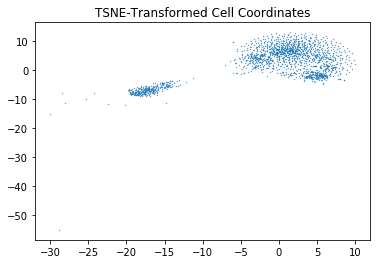

In [97]:
# iftc = forest.tsne_encoding()
iftc = forest.tsne(override=True)

# cell_id_header = np.loadtxt('/Users/boris/taylor/vision/python_prototype/raw_data/vision_sc/cell_id_header.txt',dtype='str')
# cell_ids = np.loadtxt('/Users/boris/taylor/vision/python_prototype/raw_data/vision_sc/cell_identity.txt',dtype=bool)

# mep_index = list(cell_id_header).index('MEP_narrow')

# print(mep_index)
# print(np.sum(cell_ids[:,mep_index]))

# plt.figure()
# plt.scatter(iftc[:,0],iftc[:,1],c=cell_ids[:,mep_index])
# plt.show()

Recomputing Transition Counts
16
[ 0  0  0 ...  5 15 11]
[6375, 152, 841, 211, 65, 881, 44, 814, 246, 113, 359, 782, 596, 159, 463, 449]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8


/Users/boris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


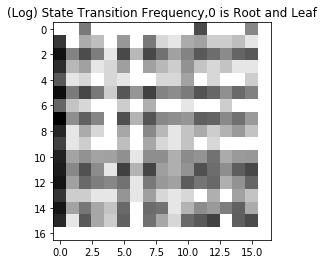

6375


./src/tree_braider2.py:1134: RuntimeWarning: invalid value encountered in true_divide
  return expit(np.log2(self.state_raw_emission_counts[state][:,0]/self.state_raw_emission_counts[state][:,1]))


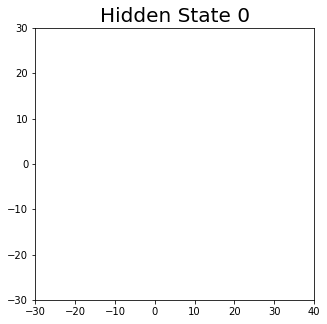

175


./src/tree_braider2.py:1134: RuntimeWarning: divide by zero encountered in true_divide
  return expit(np.log2(self.state_raw_emission_counts[state][:,0]/self.state_raw_emission_counts[state][:,1]))
./src/tree_braider2.py:1134: RuntimeWarning: divide by zero encountered in log2
  return expit(np.log2(self.state_raw_emission_counts[state][:,0]/self.state_raw_emission_counts[state][:,1]))


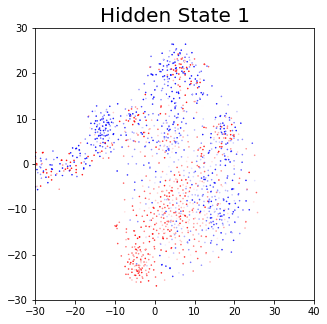

775


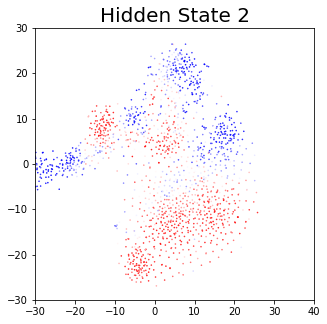

207


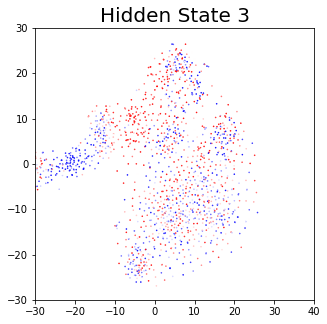

66


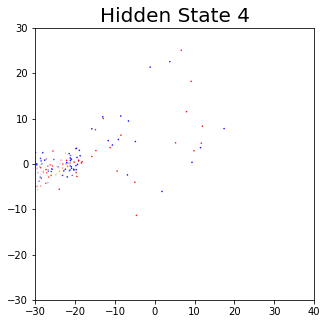

824


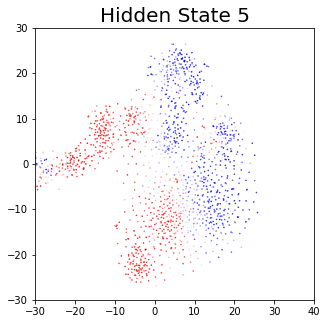

49


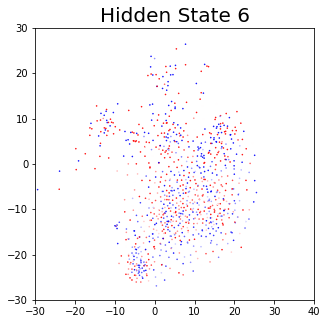

868


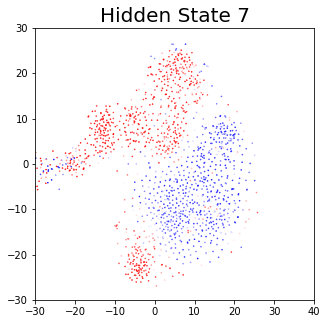

240


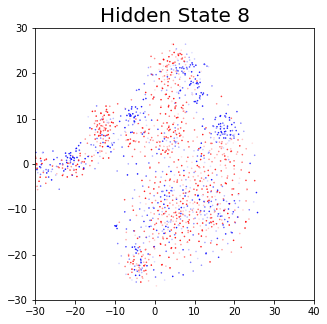

109


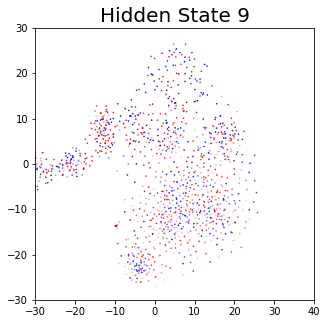

337


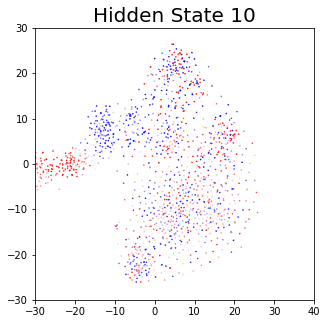

736


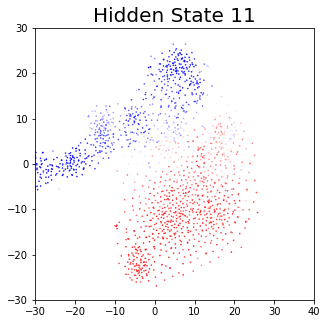

569


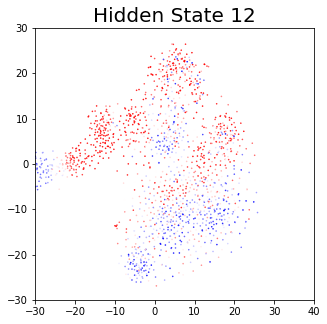

169


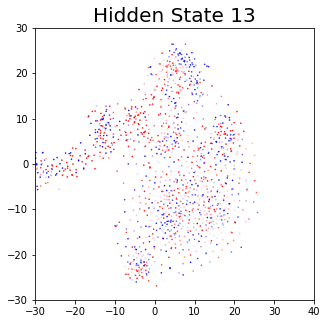

486


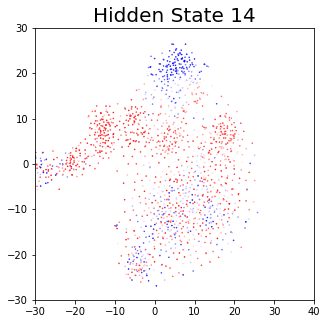

565


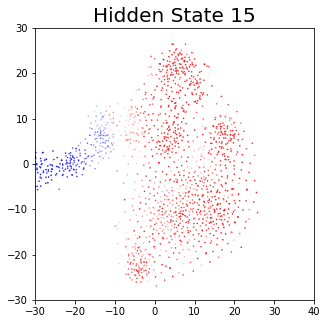

In [77]:
plt.figure()
plt.title("(Log) State Transition Frequency,0 is Root and Leaf")
plt.imshow(np.log(braid.pad_root_transitions(braid.raw_transition_counts()).T),cmap='binary')
plt.show()
  
# print(braid.state_raw_sample_odds[1])
for hidden_state in range(braid.hidden_states):
    print(np.sum(braid.state_masks[hidden_state]))
    plt.figure(figsize=(5,5))
    plt.title(f"Hidden State {hidden_state}",fontsize=20)
    plt.scatter(iftc[:,0],iftc[:,1],c=braid.lr_finite(hidden_state),cmap='bwr',s=.3)
    plt.ylim(-30,30)
    plt.xlim(-30,40)
#     plt.colorbar()
#     plt.scatter(iftc[:,0],iftc[:,1],c=braid.state_raw_sample_odds[hidden_state],s=1,cmap='PuOr')
    plt.show()
        


Recomputing Transition Counts
16
[ 0  0  0 ...  5 15 11]
[6375, 175, 775, 207, 66, 824, 49, 868, 240, 109, 337, 736, 569, 169, 486, 565]
State Index Cleanup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}
Computing State Masks
Recomputing Sample Log Odds
(16, 1654, 3)
Recomputing Transition Counts
Recomputing oracle transition count
Recomputing oracle transition count
Sampling Hypers
Beta:3
Gamma:8


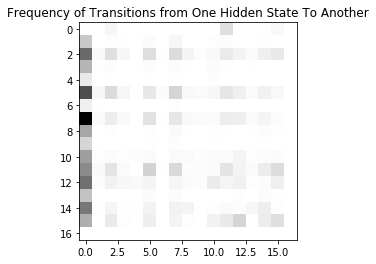

In [78]:
plt.figure()
plt.title("Frequency of Transitions from One Hidden State To Another")
plt.imshow(braid.pad_root_transitions(braid.raw_transition_counts()).T,cmap='binary')
plt.show()

./src/tree_reader.py:1506: RuntimeWarning: invalid value encountered in less
  left = gradient < .5
./src/tree_reader.py:1507: RuntimeWarning: invalid value encountered in greater_equal
  right = gradient >= .5


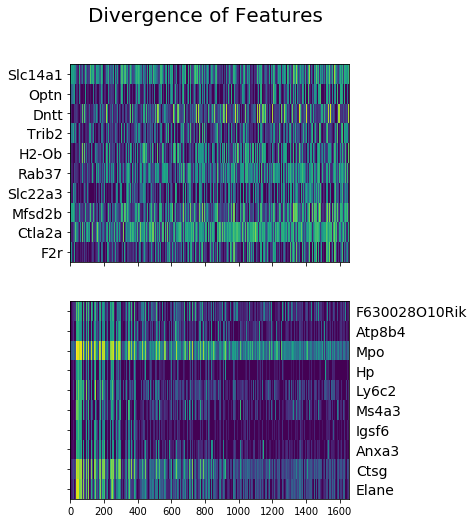

In [79]:
forest.plot_sample_feature_split(braid.lr_finite(14),plot_n=10)

In [80]:
# braid.backup('./forest_vision_braid')


In [81]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(7))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(8))[:20])


[('Ap3m2', 3), ('Dntt', 3), ('A130014A01Rik', 3), ('Prtn3', 3), ('Tnfsf4', 3), ('Fgd5', 3), ('Elmo3', 3), ('Trem3', 3), ('Gpr18', 3), ('Rhbdf1', 3), ('Serpina3f', 3), ('Olfr631', 3), ('Dkk3', 3), ('Tcrg-C4', 3), ('Psg17', 3), ('Ptk7', 3), ('Gm11282', 3), ('Cavin2', 3), ('Msrb3', 3), ('Gm14025', 3)]
[('Hmgb2', 6), ('Birc5', 6), ('Ccna2', 4), ('Ckap2l', 4), ('Bub1b', 3), ('Mki67', 3), ('Ncapg', 3), ('Spc24', 3), ('Top2a', 3), ('Kif11', 3), ('Tuba1b', 3), ('Nusap1', 3), ('Ube2c', 3), ('Shisa8', 2), ('Wdr45b', 2), ('Mis18bp1', 2), ('Ankle1', 2), ('Cdca3', 2), ('Aurkb', 2), ('Wls', 2)]


In [82]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(3))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(4))[:20])

[('Tmem176b', 4), ('Ctla2a', 4), ('Car1', 3), ('Lyz2', 3), ('Ermap', 3), ('Klhl21', 2), ('Tbc1d2b', 2), ('Cmtm6', 2), ('Kel', 2), ('Aqp1', 2), ('Parp9', 2), ('Gata1', 2), ('Atp2a3', 2), ('Pbx1', 2), ('Klf1', 2), ('Supv3l1', 2), ('Plac8', 1), ('Btnl10', 1), ('Ptpn22', 1), ('Snx4', 1)]
[('Prdm5', 1), ('Lonrf3', 1), ('4930525G20Rik', 1), ('Ube2e2', 1), ('C5ar1', 1), ('Rab6b', 1), ('Trbc1', 1), ('Tekt1', 1), ('Ckb', 1), ('Galns', 1), ('I830077J02Rik', 1), ('Sorcs2', 1), ('Hacd3', 1), ('Zfp715', 1), ('St6galnac3', 1), ('Tm9sf2', 1), ('Atg16l2', 1), ('Slco4a1', 1), ('Gm17435', 1), ('Iglc2', 1)]


In [83]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(13))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(14))[:20])

[('Ly86', 3), ('Rasa4', 3), ('Unc93b1', 2), ('Ccr2', 2), ('Gk', 2), ('Zfp512', 2), ('Apoe', 2), ('Tifab', 2), ('Cd63', 2), ('Cd63-ps', 2), ('Dhrs3', 2), ('Pkib', 2), ('H2-Aa', 2), ('I830127L07Rik', 1), ('Tomm40', 1), ('Eml5', 1), ('Nkg7', 1), ('Gm6377', 1), ('Clec4e', 1), ('Gyg', 1)]
[('Prtn3', 19), ('Mpo', 18), ('Ctsg', 18), ('Elane', 16), ('Anxa3', 10), ('Plac8', 9), ('Ms4a3', 9), ('Fcgr3', 7), ('Calr', 7), ('Hk3', 7), ('Clec12a', 7), ('Tyrobp', 6), ('Ncf1', 6), ('Hsp90b1', 6), ('Fcgr2b', 5), ('Hp', 5), ('Igsf6', 5), ('Sdf2l1', 4), ('Car2', 4), ('Epx', 4)]


In [84]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(11))[:20])

[('Cks2', 22), ('Atpif1', 20), ('Hmgb2', 17), ('Ly6a', 15), ('Hlf', 13), ('Ybx1', 12), ('Ltb', 12), ('Cdk6', 11), ('Plac8', 11), ('Cst7', 9), ('Hspe1', 7), ('Gm10039', 6), ('Gm8203', 6), ('Rps27l', 6), ('Gimap6', 6), ('Dynll1', 6), ('Olfr1258', 6), ('Ap3s1', 6), ('Mpo', 6), ('Shisa5', 5)]


In [85]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(5))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(6))[:20])

[('H2afy', 27), ('Cd34', 24), ('BC035044', 22), ('Pdzk1ip1', 20), ('Cd52', 20), ('Plac8', 20), ('Wfdc17', 20), ('Flt3', 19), ('Cd53', 17), ('Apoe', 16), ('Serpinb1a', 14), ('Adgrg3', 14), ('Ighm', 12), ('Mpl', 11), ('Tespa1', 11), ('Ramp1', 11), ('Tyrobp', 11), ('Dntt', 10), ('H2-Ob', 10), ('Sell', 10)]
[('Fos', 2), ('Inpp1', 2), ('Oat', 2), ('H2-Ab1', 1), ('Malt1', 1), ('Hmgcs1', 1), ('Cacna1a', 1), ('Igf2bp2', 1), ('Wdsub1', 1), ('Mat2a', 1), ('Inpp5b', 1), ('Fgd5', 1), ('Ercc5', 1), ('Pole3', 1), ('Smpd1', 1), ('Myof', 1), ('Lrrc8b', 1), ('Mef2a', 1), ('Nkg7', 1), ('Zfp52', 1)]


In [86]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(1))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(2))[:20])

[('Mpl', 10), ('Tbxas1', 4), ('Procr', 4), ('Dusp1', 3), ('Maged1', 2), ('Ifitm1', 2), ('Eng', 2), ('Mmrn1', 2), ('Bin2', 2), ('Cish', 2), ('Runx3', 2), ('Tfec', 2), ('Hlf', 2), ('Pafah1b2', 2), ('Snx4', 1), ('Naga', 1), ('Spag6l', 1), ('Osbpl1a', 1), ('Papss1', 1), ('Frmd4a', 1)]
[('Top2a', 20), ('Gm8203', 15), ('Tuba1b', 14), ('Spc24', 14), ('Tk1', 13), ('Rrm2', 12), ('Gmnn', 10), ('Mcm7', 10), ('Hmgb2', 10), ('Cdk1', 9), ('Dut', 9), ('Cenpk', 9), ('Lig1', 9), ('Pclaf', 8), ('Mcm5', 8), ('Slc43a3', 7), ('Uhrf1', 7), ('Cdca8', 7), ('Smc2', 7), ('Hsp90aa1', 7)]


In [87]:
for f in forest.node_feature_summary(braid.hidden_state_to_nodes(9)):
    print(f[0])

Esam
Ampd2
Txnip
Gaa
Man1a
Snx10
Dpp7
St6gal1
Stap1
Mcfd2
Tmbim1
Fdft1
Kif16b
Brat1
Tmx3
Rrad
Zfp870
Cct5
Slc5a6
Dhx58
Mapk9
Fstl1
Wdr73
Il1rl1
Gm37645
Fam107b
Hist1h4d
Chka
Coro1a
Nucb2
2610035D17Rik
Vav3
Stard7
Hspa8
Zfp7
Mapk14
Mis18bp1
Wdhd1
Epm2aip1
Zfp747
Aar2
Ranbp9
Zfp994
Anln
Anxa5
Mbtps1
Emcn
Zswim4
S1pr3
Aurkb
Klhl22
Cct3
Mr1
Cdc14a
Runx1t1
Otud6b
Glipr2
Rcan3
Gdi1
Mum1
1110059E24Rik
Crip1
Scrn3
Zfp729b
Mndal
Prpf4
Zbtb26
Cs
Bub1
Tmem209
5430403G16Rik
Lsp1
Pick1
Eif5a
Fam214b
Ccna2
Tcaim
Ptpn4
Slc19a1
Cat
Pnck
Xkr8
Arhgap18
Taf9b
Prkaa2
Coro7
Immt
Pdk2
Dph2
Rassf4
Hspa4l
Nop2
Myadm
Eya1
Rab37
Sstr2
Atp6v1a
Lrrc59
Zfp758
Nbeal2
Hjurp
Stil
Lair1
E130307A14Rik
Tubb5


In [88]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

from goatools.base import download_ncbi_associations
gene2go = download_ncbi_associations()


from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

from goatools.associations import read_ncbi_gene2go,dnld_assc

geneid2gos_mouse = read_ncbi_gene2go("gene2go", taxids=[10090])

print("{N:,} annotated mouse genes".format(N=len(geneid2gos_mouse)))

from goatools.go_enrichment import GOEnrichmentStudy
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus



  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2019-02-28) 47,399 GO Terms
  20,121 items READ: gene2go
20,121 annotated mouse genes


In [89]:
goeaobj = GOEnrichmentStudy(
        GeneID2nt_mus.keys(), # List of mouse protein-coding genes
        geneid2gos_mouse, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact
 67% 19,010 of 28,212 population items found in association


In [90]:
symbol2id = {v[5]:k for k,v in GeneID2nt_mus.items()}

def try_symbol(symbols):
    ids = []
    for symbol in symbols:
        if symbol in symbol2id:
            ids.append(symbol2id[symbol])
    return ids

In [91]:
gores = goeaobj.run_study(try_symbol([x[0] for x in forest.node_feature_summary(braid.hidden_state_to_nodes(13))]))

gores_filtered = sorted([r for r in gores if r.p_fdr_bh < 0.05],key=lambda r: r.p_fdr_bh)

gores_filtered = [g for g in gores_filtered if g.goterm.namespace == 'biological_process' or g.goterm.namespace == 'molecular_function']

print(gores_filtered)

 96%    139 of    145 study items found in association
100%    145 of    145 study items found in population(28212)
Calculating 18,000 uncorrected p-values using fisher_scipy_stats
  18,000 GO terms are associated with 19,010 of 28,212 population items
   1,509 GO terms are associated with    139 of    145 study items
      14 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh
[GOEnrichmentRecord(GO:0002376), GOEnrichmentRecord(GO:0005515), GOEnrichmentRecord(GO:0000166), GOEnrichmentRecord(GO:0005524), GOEnrichmentRecord(GO:0045087), GOEnrichmentRecord(GO:0030097), GOEnrichmentRecord(GO:0071723), GOEnrichmentRecord(GO:0016740), GOEnrichmentRecord(GO:0016310), GOEnrichmentRecord(GO:0016301)]


In [92]:
# gores_filtered[1].__dict__

In [93]:
[go.name for go in gores_filtered]

['immune system process',
 'protein binding',
 'nucleotide binding',
 'ATP binding',
 'innate immune response',
 'hemopoiesis',
 'lipopeptide binding',
 'transferase activity',
 'phosphorylation',
 'kinase activity']

In [94]:
for term in [go.name for go in gores_filtered]:
    print(term)

immune system process
protein binding
nucleotide binding
ATP binding
innate immune response
hemopoiesis
lipopeptide binding
transferase activity
phosphorylation
kinase activity


In [95]:
def hidden_state_sample_cluster_matrix(forest,braid):
    state_cluster_matrix = np.zeros((len(forest.sample_clusters),braid.hidden_states))
    for i,sample_cluster in enumerate(forest.sample_clusters):
        for j,hidden_state in enumerate(braid.state_sample_log_odds):
            odds_sample_x_cluster = hidden_state[sample_cluster.samples]
            state_cluster_matrix[i,j] = np.mean(odds_sample_x_cluster)
    return state_cluster_matrix

In [96]:
clusters_x_hs = hidden_state_sample_cluster_matrix(forest,braid)

cluster_sort = np.array(dendrogram(linkage(clusters_x_hs,method='average'),no_plot=True)['leaves'])
hs_sort = np.argsort([np.mean([n.level for n in braid.hidden_state_to_nodes(hs)]) for hs in range(braid.hidden_states)])
# hs_sort = np.array(dendrogram(linkage(clusters_x_hs.T,method='average'),no_plot=True)['leaves'])

cell_cluster_mask = np.array([len(c.samples) > 40 for c in forest.sample_clusters])
cell_cluster_mask = cell_cluster_mask[cluster_sort]

hidden_state_mask = np.array([np.sum(hsm) > 100 for hsm in braid.state_masks[:,braid.live_mask]])
print(hidden_state_mask)
hidden_state_mask = hidden_state_mask[hs_sort]

IndexError: index 16 is out of bounds for axis 1 with size 16

In [ ]:
plt.figure()
plt.title("Fit of Cell Clusters To Hidden States")
plt.imshow(clusters_x_hs[cluster_sort][cell_cluster_mask].T[hs_sort][hidden_state_mask],aspect='auto')
plt.ylabel("Hidden States")
plt.xlabel("Cell Clusters")
plt.xticks(np.arange(len(cluster_sort[cell_cluster_mask])),cluster_sort[cell_cluster_mask])
plt.yticks(np.arange(len(hs_sort[hidden_state_mask])),hs_sort[hidden_state_mask])
plt.colorbar()
plt.show()